# Quantum pipeline using t|ket> backend
This performs a shots-based simulation.

In [1]:
import numpy as np

def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            labels.append([1, 0] if line[0] == '1' else [0, 1])
            sentences.append(line[1:].strip())
    return np.array(labels), sentences


train_labels, train_data = read_data('datasets/mc_train_data.txt')
dev_labels, dev_data = read_data('datasets/mc_dev_data.txt')
test_labels, test_data = read_data('datasets/mc_test_data.txt')

### Create diagrams

In [2]:
from lambeq import NewCCGParser

reader = NewCCGParser()

raw_train_diagrams = reader.sentences2diagrams(train_data)
raw_dev_diagrams = reader.sentences2diagrams(dev_data)
raw_test_diagrams = reader.sentences2diagrams(test_data)

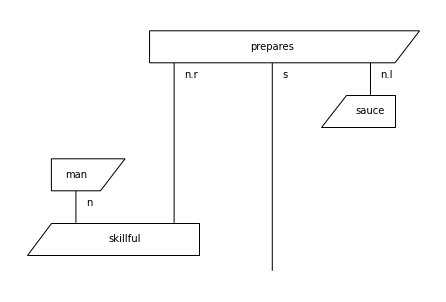

In [3]:
from discopy.rigid import Id


def remove_cups(diagram):
    # Remove cups to reduce post-selection in the circuit, for faster execution

    diags = []
    for box, offset in zip(diagram.boxes, diagram.offsets):
        if not box.dom:  # word box
            diags.insert(offset, box)
        else:  # cup (the only other type of box in these diagrams)
            i = 0
            off = offset
            while off != len(diags[i].cod) - 1:
                assert off > 0
                off -= len(diags[i].cod)
                i += 1
            left, right = diags[i:i+2]
            
            if len(left.cod) == 1:
                new_diag = right >> (left.r.dagger() @ Id(right.cod[1:]))
            else:
                assert len(right.cod) == 1
                new_diag = left >> (Id(left.cod[:-1]) @ right.l.dagger())

            diags[i:i+2] = [new_diag]

    assert len(diags) == 1
    return diags[0]


train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_dev_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

train_diagrams[0].draw()

### Create circuits

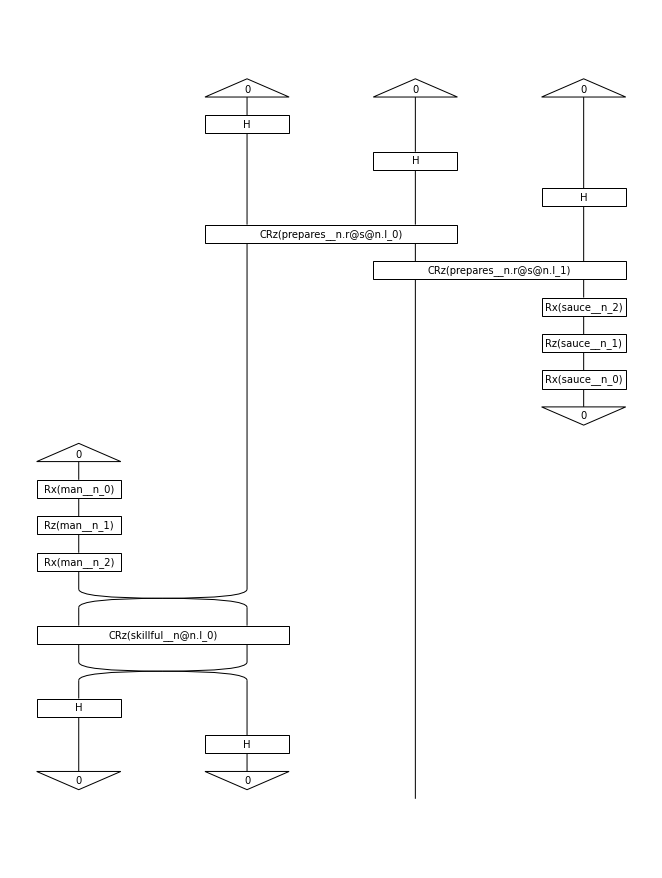

In [4]:
from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(9, 12))

### Parameterise

In [5]:
from sympy import default_sort_key

all_circuits = train_circuits + dev_circuits + test_circuits

# sort the symbols since they are returned as a set
parameters = sorted(
    {s for circ in all_circuits for s in circ.free_symbols},
    key=default_sort_key)

In [6]:
## CONFIGURE BACKEND
# This uses Qiskit, which requires installing `pytket-qiskit`.
# For more information on how to use pytket with different backends, see:
# https://cqcl.github.io/pytket/build/html/extensions/

# Aer is a shots-based backend that is always available.

from pytket.extensions.qiskit import AerBackend
backend = AerBackend()

## Having an IBMQ account gives access to the IBM emulator for noisy simulations:
#
# from pytket.extensions.qiskit import IBMQEmulatorBackend
# backend = IBMQEmulatorBackend('PLACEHOLDER')
#
## To use a real device:
#
# from pytket.extensions.qiskit import IBMQBackend
# backend = IBMQBackend('PLACEHOLDER')

backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'n_shots': 8192  # maximum recommended shots, reduces sampling error
}

In [7]:
from discopy.quantum import Circuit, Id, Measure


def randint(rng, low=-1 << 63, high=1 << (63-1)):
    return rng.integers(low, high)


def normalise(predictions):
    # apply smoothing to predictions
    predictions = np.abs(predictions) + 1e-9
    return predictions / predictions.sum()


def make_pred_fn(circuits, rng):
    measured_circuits = [c >> Id().tensor(*[Measure()] * len(c.cod)) for c in circuits]
    circuit_fns = [c.lambdify(*parameters) for c in measured_circuits]

    def predict(params):
        outputs = Circuit.eval(*(c_fn(*params) for c_fn in circuit_fns),
                               **backend_config, seed=randint(rng))
        backend_config['backend'].empty_cache()
        return np.array([normalise(output.array) for output in outputs])
    return predict


SEED = 0
rng = np.random.default_rng(SEED)

train_pred_fn = make_pred_fn(train_circuits, rng)
dev_pred_fn = make_pred_fn(dev_circuits, rng)
test_pred_fn = make_pred_fn(test_circuits, rng)

### Train

In [8]:
from noisyopt import minimizeSPSA

def make_cost_fn(pred_fn, labels):
    def cost_fn(params, **kwargs):
        predictions = pred_fn(params)

        cost = -np.sum(labels * np.log(predictions)) / len(labels)  # binary cross-entropy loss
        costs.append(cost)

        acc = np.sum(np.round(predictions) == labels) / len(labels) / 2  # half due to double-counting
        accuracies.append(acc)

        return cost

    costs, accuracies = [], []
    return cost_fn, costs, accuracies


train_cost_fn, train_costs, train_accs = make_cost_fn(train_pred_fn, train_labels)
dev_cost_fn, dev_costs, dev_accs = make_cost_fn(dev_pred_fn, dev_labels)

x0 = np.array(rng.random(len(parameters)))
np.random.seed(SEED)
result = minimizeSPSA(train_cost_fn, x0=x0, a=0.2, c=0.06, niter=80, callback=dev_cost_fn)

### Show results

Test accuracy: 0.9333333333333333


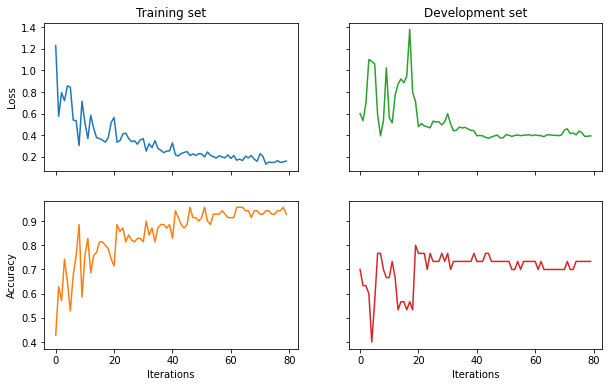

In [9]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(train_costs[1::2], color=next(colours))  # training evaluates twice per iteration
ax_bl.plot(train_accs[1::2], color=next(colours))   # so take every other entry
ax_tr.plot(dev_costs, color=next(colours))
ax_br.plot(dev_accs, color=next(colours))

# print test accuracy
test_cost_fn, _, test_accs = make_cost_fn(test_pred_fn, test_labels)
test_cost_fn(result.x)
print('Test accuracy:', test_accs[0])